# Konnektor - Graph Benchmarking


In [1]:
# NBVAL_SKIP
# Only run this cell if on google colab
import os
if "COLAB_RELEASE_TAG" in os.environ:
    !pip install -U https://github.com/conda-incubator/condacolab/archive/cuda-version-12.tar.gz
    import condacolab
    condacolab.install_mambaforge()
    !wget -q https://raw.githubusercontent.com/OpenFreeEnergy/konnektor/main/examples/environment.yaml
    !mamba env update -q --name=base --file=environment.yaml


# Calculate networks

In [2]:
from tqdm.auto import tqdm
from datetime import datetime
import numpy as np
import pandas as pd
from konnektor import network_analysis as ana
from konnektor.utils.toy_data import build_random_dataset
from konnektor.network_planners import (MaximalNetworkGenerator, 
                                        RadialLigandNetworkPlanner, 
                                        StarrySkyNetworkGenerator,
                                        MinimalSpanningTreeNetworkGenerator, 
                                        RedundantMinimalSpanningTreeNetworkGenerator,
                                        CyclicNetworkGenerator, ClusteredNetworkGenerator)

networker = [ RadialLigandNetworkPlanner, StarrySkyNetworkGenerator,
             MinimalSpanningTreeNetworkGenerator, RedundantMinimalSpanningTreeNetworkGenerator,
             CyclicNetworkGenerator,
             ClusteredNetworkGenerator, MaximalNetworkGenerator
            ]

nCompounds = np.linspace(5, 40, 10,  dtype=int)
nSamples = 3
ncomp=[]
for n in tqdm(nCompounds, desc="nCompounds"):

    for i in range(nSamples):
        compounds, genMapper, genScorer= build_random_dataset(n_compounds=n)
    
        for net in networker:
            try:
                start = datetime.now()
                planner = net(mapper=genMapper, scorer=genScorer)
                    
                #Build
                network = planner(compounds)
                network.name= planner.__class__.__name__.replace("Planner", "").replace("MinimalSpanningTree", "MST").replace("Ligand", "")
                end = datetime.now()
                #Stats
                nEdges=len(network.edges)
                graph_score = ana.network_analysis.get_graph_score(network)
                isConnected = ana.network_analysis.get_is_connected(network)
                nCycles = ana.network_analysis.get_number_of_graph_cycles(network)
                r = ana.get_edge_failure_robustness(network, 0.10)
                r2 = ana.get_edge_failure_robustness(network, 0.5)
                duration=end-start
                
                ncomp.append({"ntype":network.name, "sample":i, "nmols":n, "graphScore":graph_score, 
                              "connected":isConnected, "nEdges":nEdges, 
                              "robustness":r, "robustnesshalf":r2, 
                              "nCycles":nCycles, "time":duration.microseconds,
                              "network": network})
            
            except Exception as err:
                #raise err
                print(net, i, n)
                print(err.args)
                pass
    break
df = pd.DataFrame(ncomp)

nCompounds:   0%|          | 0/10 [00:00<?, ?it/s]

dict_keys([-1])
<class 'konnektor.network_planners.generators.two_dimensional_network_planners.StarrySkyNetworkGenerator'> 0 5
('Found only noise cluster nodes!',)
ERR list index out of range
dict_keys([-1])
<class 'konnektor.network_planners.generators.two_dimensional_network_planners.StarrySkyNetworkGenerator'> 1 5
('Found only noise cluster nodes!',)
ERR list index out of range
dict_keys([-1])
<class 'konnektor.network_planners.generators.two_dimensional_network_planners.StarrySkyNetworkGenerator'> 2 5
('Found only noise cluster nodes!',)
ERR list index out of range


/tmp/ipykernel_9227/1793712053.py:154: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


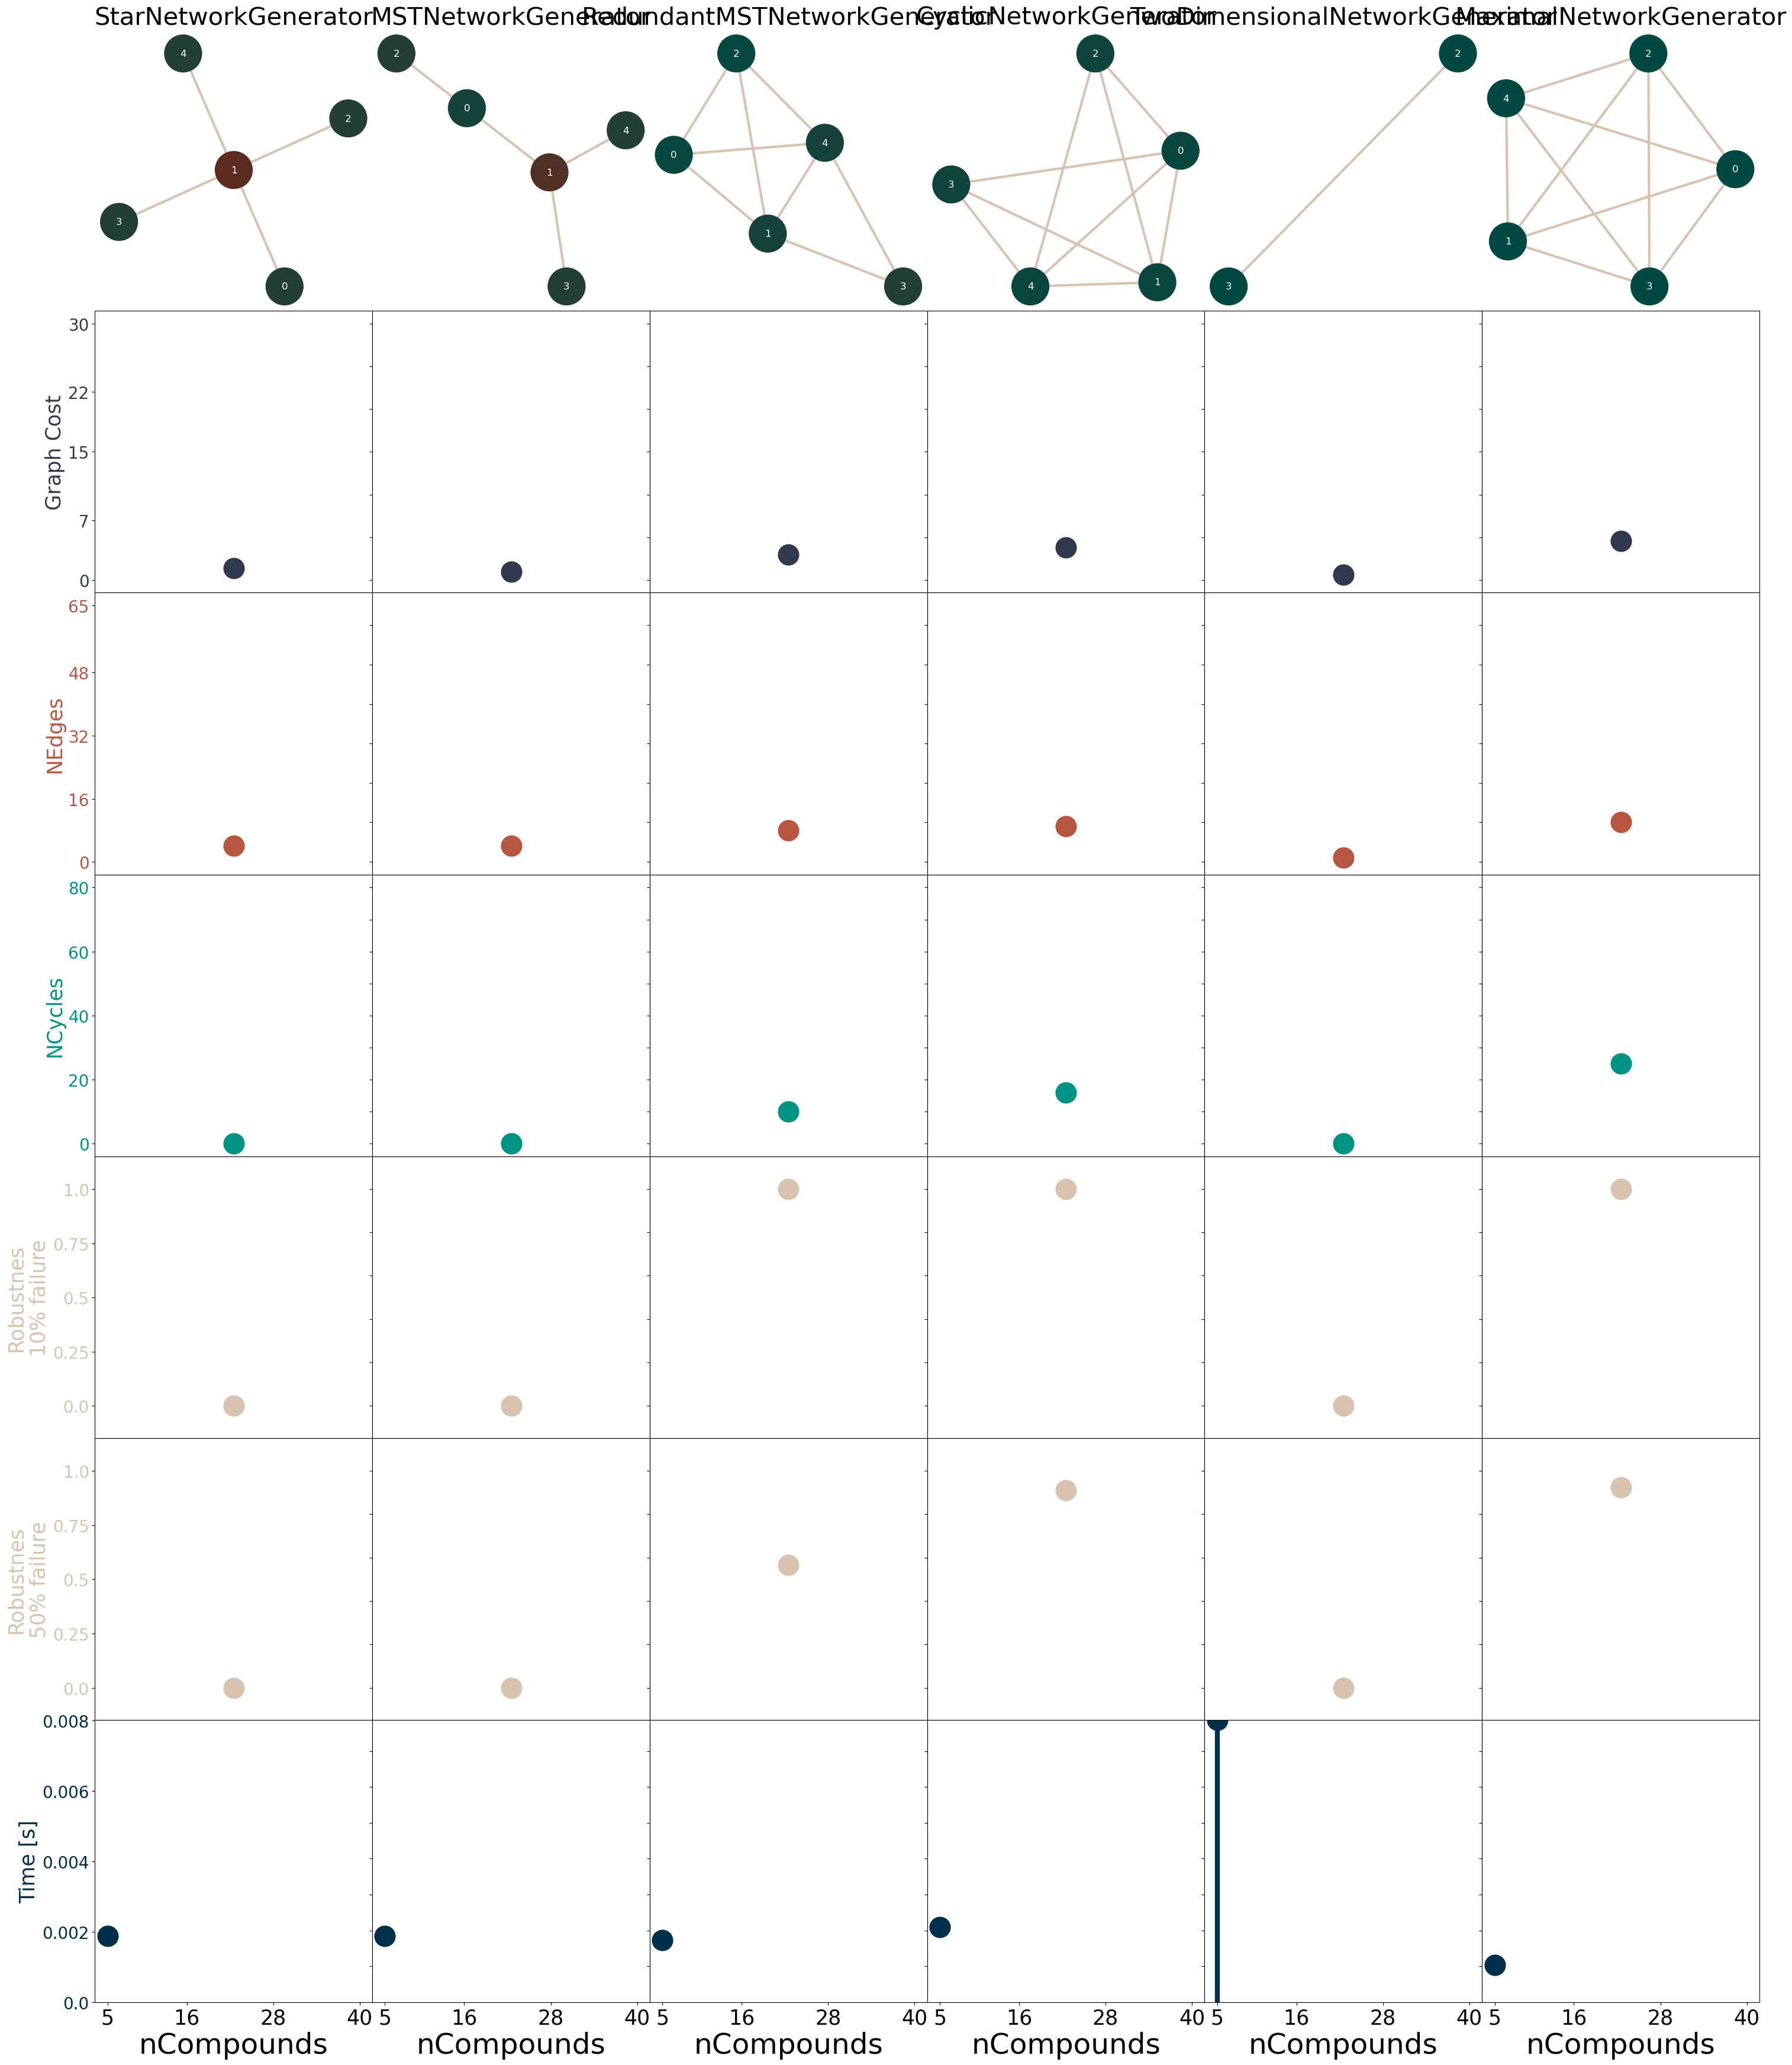

In [3]:
from matplotlib import pyplot as plt
from konnektor.visualization import draw_ligand_network
from konnektor.visualization.visualization import OFE_COLORS
df = pd.DataFrame(ncomp)
network_names =  list(df.ntype.unique())

ncols=len(network_names)
nrows = 7
fig, axes_cols = plt.subplots(nrows=nrows, ncols=ncols, figsize=[5*ncols,5*nrows],)

m = df.nmols.max()
networks =  [df.sort_values(by="nmols").loc[(df.ntype == n) & (df.nmols >= 5)].network.iloc[0]  for n in network_names]
graph_score_mean = [[df.loc[(df.ntype == n) & (df.nmols == c)].graphScore.mean()  for c in nCompounds] for n in network_names]
graph_score_std = [[df.loc[(df.ntype == n) & (df.nmols == c)].graphScore.std()  for c in nCompounds] for n in network_names]

nedges_mean = [[df.loc[(df.ntype == n) & (df.nmols == c)].nEdges.mean()  for c in nCompounds] for n in network_names]
nedges_std = [[df.loc[(df.ntype == n) & (df.nmols == c)].nEdges.std()  for c in nCompounds] for n in network_names]

robustness_mean = [[df.loc[(df.ntype == n) & (df.nmols == c)].robustness.mean()  for c in nCompounds] for n in network_names]
robustness_std = [[df.loc[(df.ntype == n) & (df.nmols == c)].robustness.std()  for c in nCompounds] for n in network_names]

robustnesshalf_mean = [[df.loc[(df.ntype == n) & (df.nmols == c)].robustnesshalf.mean()  for c in nCompounds] for n in network_names]
robustnesshalf_std = [[df.loc[(df.ntype == n) & (df.nmols == c)].robustnesshalf.std()  for c in nCompounds] for n in network_names]

ncycles_mean = [[df.loc[(df.ntype == n) & (df.nmols == c)].nCycles.mean()  for c in nCompounds] for n in network_names]
ncycles_std = [[df.loc[(df.ntype == n) & (df.nmols == c)].nCycles.std()  for c in nCompounds] for n in network_names]

time_mean = [[df.loc[(df.ntype == n) & (df.nmols == c)].time.mean()  for c in nCompounds] for n in network_names]
time_std = [[df.loc[(df.ntype == n) & (df.nmols == c)].time.std()  for c in nCompounds] for n in network_names]


for i,n in enumerate(network_names):
    axes = axes_cols.T[i]

    try:
        draw_ligand_network(networks[i], title=networks[i].name, ax=axes[0], fontsize=30)
    except Exception as err:
        raise err

    
    axes[1].errorbar(nCompounds, graph_score_mean[i], yerr=graph_score_std[i], label=n, marker="o", color=OFE_COLORS[0], lw=6, ms=25)
    axes[2].errorbar(nCompounds, nedges_mean[i], yerr=nedges_std[i], label=n, marker="o", color=OFE_COLORS[1], lw=6, ms=25)
    axes[3].errorbar(nCompounds, ncycles_mean[i], yerr=ncycles_std[i], label=n, marker="o", color=OFE_COLORS[2], lw=6, ms=25)
    axes[4].errorbar(nCompounds, robustness_mean[i], yerr=robustness_std[i], label=n, marker="o", color=OFE_COLORS[3], lw=6, ms=25)
    axes[5].errorbar(nCompounds, robustnesshalf_mean[i], yerr=robustnesshalf_std[i], label=n, marker="o", color=OFE_COLORS[4], lw=6, ms=25)
    axes[6].errorbar(nCompounds, time_mean[i], yerr=time_std[i], label=n, marker="o", color=OFE_COLORS[6], lw=6, ms=25)

    off=-2 # used to be -2
    if(i == 0):
        axes[1].set_ylabel("Graph Cost", fontsize=25, color=OFE_COLORS[0])    
        axes[2].set_ylabel("NEdges", fontsize=25, color=OFE_COLORS[1])    
        axes[3].set_ylabel("NCycles", fontsize=25, color=OFE_COLORS[2])
        axes[4].set_ylabel("Robustnes\n10% failure", fontsize=25, color=OFE_COLORS[3])
        axes[5].set_ylabel("Robustnes\n50% failure", fontsize=25, color=OFE_COLORS[4])
        axes[6].set_ylabel("Time [s]", fontsize=25, color=OFE_COLORS[6])

        minV = 0 #np.min(np.nan_to_num(graph_score_mean))
        #maxV = np.max(np.nan_to_num(graph_score_mean[::off]))*2
        maxV = 30
        tics = np.linspace(minV, maxV, 5, dtype=int)
        d = maxV-minV
        axes[1].set_ylim([minV-d*0.05, maxV+d*0.05])
        axes[1].set_yticks(tics)    
        axes[1].set_yticklabels(tics, fontsize=20, color=OFE_COLORS[0])    

        minV = 0# np.min(np.nan_to_num(nedges_mean))
        #maxV = np.max(np.nan_to_num(nedges_mean[::off]))*2
        maxV=65
        tics = np.linspace(minV, maxV, 5, dtype=int)
        d = maxV-minV
        axes[2].set_ylim([minV-d*0.05, maxV+d*0.05])
        axes[2].set_yticks(tics)    
        axes[2].set_yticklabels(tics, fontsize=20, color=OFE_COLORS[1])    

        minV = 0 #np.min(np.nan_to_num(ncycles_mean[::-2]))
        maxV = np.max(np.nan_to_num(ncycles_mean[::off]))
        maxV=80
        tics = np.linspace(minV, maxV, 5, dtype=int)
        d = maxV-minV
        axes[3].set_ylim([minV-d*0.05, maxV+d*0.05])
        axes[3].set_yticks(tics)    
        axes[3].set_yticklabels(tics, fontsize=20, color=OFE_COLORS[2])   
        
        minV = 0
        maxV = 1
        tics = np.round(np.linspace(0, 1, 5),2)
        axes[4].set_ylim([minV-0.15, maxV+0.15])
        axes[4].set_yticks(tics)    
        axes[4].set_yticklabels(tics, fontsize=20, color=OFE_COLORS[3])    
        
        axes[5].set_ylim([minV-0.15, maxV+0.15])
        axes[5].set_yticks(tics)    
        axes[5].set_yticklabels(tics, fontsize=20, color=OFE_COLORS[4])   

        minV = 0 #np.min(np.nan_to_num(ncycles_mean[::off]))
        maxV = np.max(np.nan_to_num(time_mean))
        tics = np.linspace(minV, maxV, 5, dtype=int)
        d = maxV-minV
        axes[6].set_ylim([minV-0.15, maxV+0.15])
        axes[6].set_yticks(tics)    
        axes[6].set_yticklabels(np.round(tics*10**-6,3), fontsize=20, color=OFE_COLORS[6])   
        
    else:
        axes[1].set_yticklabels([])      
        axes[2].set_yticklabels([])      
        axes[3].set_yticklabels([])      
        axes[4].set_yticklabels([]) 
        axes[5].set_yticklabels([]) 
        axes[6].set_yticklabels([]) 

        minV = 0
        #maxV = np.max(np.nan_to_num(graph_score_mean[::off]))*2
        maxV = 30
        d = maxV-minV
        axes[1].set_ylim([minV-d*0.05, maxV+d*0.05])

        minV = 0 #np.min(np.nan_to_num(nedges_mean))
        #maxV = np.max(np.nan_to_num(nedges_mean[::off]))*2
        maxV=65
        d = maxV-minV
        axes[2].set_ylim([minV-d*0.05, maxV+d*0.05])

        minV = 0
        maxV = np.max(np.nan_to_num(ncycles_mean[::off]))*2
        maxV=80
        d = maxV-minV
        axes[3].set_ylim([minV-d*0.05, maxV+d*0.05])
        
        minV = 0
        maxV = 1
        axes[4].set_ylim([minV-0.15, maxV+0.15])
        axes[5].set_ylim([minV-0.15, maxV+0.15])

        minV = 0 #np.min(np.nan_to_num(ncycles_mean[::off]))
        maxV = np.max(np.nan_to_num(time_mean))
        axes[6].set_ylim([minV-0.15, maxV+0.15])

    for j in range(nrows):
        axes[j].set_xticklabels([])


    minV = 5
    maxV = 40 #max(nCompounds)
    d = maxV - minV
    tics = np.linspace(minV, maxV, 4, dtype=int)
    axes[-1].set_xticks(tics)
    axes[-1].set_xticklabels(tics, rotation=0, fontsize=25)
    axes[-1].set_xlim([minV-0.05*d, maxV+0.05*d])
    axes[-1].set_xlabel("nCompounds", fontsize=35)
    axes[0].axis("off")

fig.tight_layout()
fig.subplots_adjust(hspace=0, wspace=0)
fig.show()

In [4]:
fig.savefig("../.img/Network_Overview.png")